# KITTI Evaluation

In [1]:
"""
Load dataset
"""

import os

data_path = os.path.abspath("../dataset/parsed_dataset/parsed_kitti_data.pickle")


import pickle

with open(data_path, 'rb') as f:
    parsed_kitti_data = pickle.load(f)

print "Dataset was loaded"

Dataset was loaded


In [2]:
"""
Data structure
"""

for date in parsed_kitti_data:
    print "date:", date
    
    for drive in parsed_kitti_data[date]:
        print "\tdrive:", drive
        
        for tracklets_list in parsed_kitti_data[date][drive]:
            print "\t\ttrack: ",
            for key in tracklets_list:
                print " ", key,               
            print "{}".format(len(tracklets_list[key]))

date: 2011_09_26
	drive: 0017
		track:    pc   trans   type   rect   rot 8
		track:    pc   trans   type   rect   rot 24
		track:    pc   trans   type   rect   rot 27
		track:    pc   trans   type   rect   rot 25
	drive: 0005
		track:    pc   trans   type   rect   rot 154
		track:    pc   trans   type   rect   rot 154
		track:    pc   trans   type   rect   rot 6
		track:    pc   trans   type   rect   rot 103
		track:    pc   trans   type   rect   rot 9
		track:    pc   trans   type   rect   rot 35
		track:    pc   trans   type   rect   rot 33
		track:    pc   trans   type   rect   rot 33
		track:    pc   trans   type   rect   rot 28
		track:    pc   trans   type   rect   rot 34
		track:    pc   trans   type   rect   rot 30
		track:    pc   trans   type   rect   rot 24
		track:    pc   trans   type   rect   rot 16
		track:    pc   trans   type   rect   rot 16
		track:    pc   trans   type   rect   rot 28
	drive: 0002
		track:    pc   trans   type   rect   rot 11
		track:    pc   trans  

## Registration Evaluation


/home/kyungpyo/.local/lib/python2.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: Non length-one string passed in for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


Registration visualization [pcl_icp] - data: rot


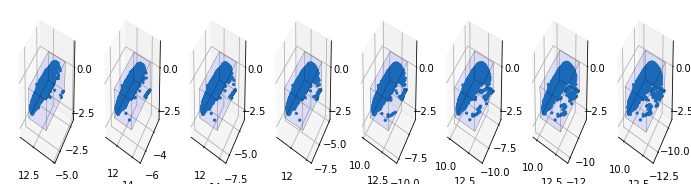

/home/kyungpyo/.local/lib/python2.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: Non length-one string passed in for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


Registration visualization [pcl_gicp] - data: rot


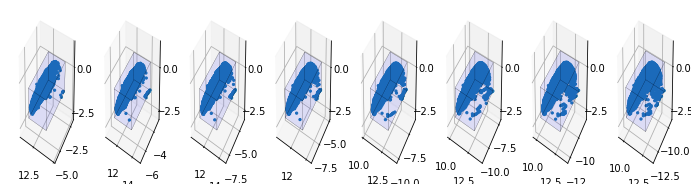

/home/kyungpyo/.local/lib/python2.7/site-packages/ipykernel_launcher.py:87: DeprecationWarning: Non length-one string passed in for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


Registration visualization [pcl_icp_nl] - data: rot


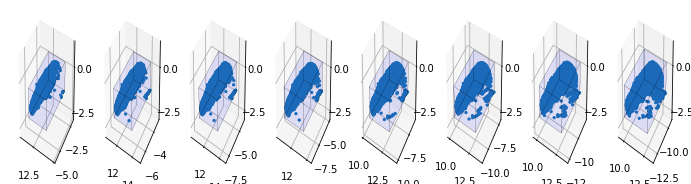

In [13]:
"""
Point cloud with registration (pcl)
"""

import numpy as np
import pcl
import copy
import time

from transformation import *
from visualization import *


"""
test track
"""
track = parsed_kitti_data[date]['0017'][0]


method_list = [ 'pcl_icp', 'pcl_gicp', 'pcl_icp_nl']
registration_results = {}

for method in method_list:

    """
    Results
    """
    registration_results[method] = {}
    
    """ 
    Evaluation metrices
    """
    registration_results[method] = {}
    registration_results[method]['xyz_rmse'] = []

    source_list = []
    target_list = []
    acc_list = []

    source = track['pc'][0][:,:3].copy()
    target = None
    acc = None

    acc_list.append(source.copy())

    
    for frame in range(1, len(track['pc'])):

        ## Set target point cloud
        del target
        target = track['pc'][frame][:,:3].copy()

        source_list.append(source.astype(np.float32).copy())
        target_list.append(target.astype(np.float32).copy())

        # convert to pcl type
        pcl_src_cloud = pcl.PointCloud(source.astype(np.float32).copy())
        pcl_trg_cloud = pcl.PointCloud(target.astype(np.float32).copy())


        ## run registration

        # parameters
        iteration = 200

        start_time = time.time()
        if method == 'pcl_icp':

            pcl_icp = pcl_src_cloud.make_IterativeClosestPoint()

            converged, mat_tf, estimate, finess = pcl_icp.icp(pcl_src_cloud,
                                                             pcl_trg_cloud,
                                                             max_iter = iteration)   
        elif method == 'pcl_gicp':

            pcl_icp = pcl_src_cloud.make_GeneralizedIterativeClosestPoint()

            converged, mat_tf, estimate, finess = pcl_icp.gicp(pcl_src_cloud,
                                                             pcl_trg_cloud,
                                                             max_iter = iteration)   
        elif method == 'pcl_icp_nl':

            pcl_icp = pcl_src_cloud.make_IterativeClosestPointNonLinear()

            converged, mat_tf, estimate, finess = pcl_icp.icp_nl(pcl_src_cloud,
                                                             pcl_trg_cloud,
                                                             max_iter = iteration)   

        ## accumulation

        source_trans = transform_pointcloud_affine(source.copy(), mat_tf)

        del acc
        acc = np.concatenate((target, source_trans), axis = 0)
        acc_list.append(acc.copy())

        y_gt = track['rot'][frame][2] - track['rot'][frame-1][2]
        assert np.abs(track['rot'][frame][:2]).sum() == 0
        
        trsns_gt = track['trans'][frame] - track['trans'][frame-1]
        
        rotMat = np.array([[np.cos(y_gt), -np.sin(y_gt), 0.0],
                           [np.sin(y_gt), np.cos(y_gt), 0.0],
                           [0.0, 0.0, 1.0]])
        
        # calculation RMSE
        source_trans_gt = np.dot(rotMat, source.copy().T).T
        source_trans_gt[:,0] += trsns_gt[0]
        source_trans_gt[:,1] += trsns_gt[1]
        source_trans_gt[:,2] += trsns_gt[2]
        
        error = source_trans_gt - source_trans
        rmse = np.sqrt(np.mean(error**2, axis = 0))
        registration_results[method]['xyz_rmse'].append(rmse)

        ## update source point cloud
        del source
        pcl_acc = pcl.PointCloud(acc.astype(np.float32).copy())
        pcl_acc_vf = pcl_acc.make_voxel_grid_filter()
        pcl_acc_vf.set_leaf_size(0.1, 0.1, 0.1)

        source = np.array(pcl_acc_vf.filter())


    ## visualization
    %matplotlib inline
    print "Registration visualization [{}] - data: {}".format(method, key)
    fig = plt.figure(figsize=(12,3))
    for i in range( len( acc_list ) ):

        ax = fig.add_subplot(1,len( acc_list ), i+1, projection='3d')
        resample_data = resample_point_cloud( acc_list[i], 1.0)
        display_point_cloud_box_ax_test(ax, resample_data)

    plt.draw()
    plt.show(block=True)

method_list.append('layer-based accumulation')

In [14]:
import pcl
import numpy as np
import copy

from registration import *
from visualization import *

def layered_registration_test(source, target, iteration, prev_source = np.array([])):
        
    """ parameters """
    # layer boundary condition
    l1_bnd = 0.4 - 1.5
    l2_bnd = 0.8 - 1.5
    l3_bnd = 1.2 - 1.5
    h_bnd = 0.2

    tolerance = 0.001

    """ init pose estimation """ 
    # prev point cloud
    init_pose = np.eye(3)

    if prev_source.shape[0] > 0 :
        
        ps = prev_source.copy()
        ps[:,2] = 0
        tl = target.copy()
        tl[:,2] = 0
        
        ps_pcl = pcl.PointCloud(ps.astype(np.float32).copy())
        tl_pcl = pcl.PointCloud(tl.astype(np.float32).copy())
        
        ps_pcl_vf = ps_pcl.make_voxel_grid_filter()
        ps_pcl_vf.set_leaf_size(0.2, 0.2, 0.2)
        
        del ps
        ps = np.array(ps_pcl_vf.filter())
        
        tl_pcl_vf = tl_pcl.make_voxel_grid_filter()
        tl_pcl_vf.set_leaf_size(0.2, 0.2, 0.2)
        
        del tl
        tl = np.array(tl_pcl_vf.filter())
        
        init_pose, _, _, _, me1, mat_pt_num1 = icpMatchingPointNum(ps[:, :2],
                                tl[:, :2],
                                init_pose = init_pose,
                                max_iterations = 100,
                                tolerance = tolerance,
                                rm_outlier_dist = 10.)
        

    """ layer-based sampling """
    # layer1
    tl1 = target.copy()
    tl1 = tl1[ tl1[:,2] < l1_bnd]

    l1_s_bnd = np.mean( tl1[:,2] )

    sl1 = source.copy()
  
    sl1 = sl1[ sl1[:,2] < l1_s_bnd + h_bnd ]
    sl1 = sl1[ sl1[:,2] > l1_s_bnd - h_bnd ]

    # layer2
    tl2 = target.copy()
    tl2 = tl2[ tl2[:,2] < l2_bnd ]
    tl2 = tl2[ tl2[:,2] > l1_bnd ] 

    l2_s_bnd = np.mean( tl2[:,2] )

    sl2 = source.copy()
    sl2 = sl2[ sl2[:,2] < l2_s_bnd + h_bnd ]
    sl2 = sl2[ sl2[:,2] > l2_s_bnd - h_bnd ]
    
    # layer3
    tl3 = target.copy()
    tl3 = tl3[ tl3[:,2] < l3_bnd ]
    tl3 = tl3[ tl3[:,2] > l2_bnd ] 

    l3_s_bnd = np.mean( tl3[:,2] )

    sl3 = source.copy()
    sl3 = sl3[ sl3[:,2] < l3_s_bnd + h_bnd ]
    sl3 = sl3[ sl3[:,2] > l3_s_bnd - h_bnd ]

    # layer4
    tl4 = target.copy()
    tl4 = tl4[ tl4[:,2] > l3_bnd ] 

    l4_s_bnd = np.mean( tl4[:,2] )

    sl4 = source.copy()
    sl4 = sl4[ sl4[:,2] < l4_s_bnd + h_bnd ]
    sl4 = sl4[ sl4[:,2] > l4_s_bnd - h_bnd ]
            
    # matching1
    if tl1.shape[0] > 0 and sl1.shape[0] > 0:
        mat_tf1, _, _, _, me1, mat_pt_num1 = icpMatchingPointNum(sl1[:, :2],
                                        tl1[:, :2],
                                        init_pose = init_pose,
                                        max_iterations = 100,
                                        tolerance = tolerance,
                                        rm_outlier_dist = 0.3)
    else:
        mat_tf1 = init_pose.copy()
        me1 = tolerance * 10.
        mat_pt_num1 = 0
        

    # matching2
    if tl2.shape[0] > 0 and sl2.shape[0] > 0:
        mat_tf2, _, _, _, me2, mat_pt_num2 = icpMatchingPointNum(sl2[:, :2],
                                        tl2[:, :2],
                                        init_pose = init_pose,
                                        max_iterations = 100,
                                        tolerance = tolerance,
                                        rm_outlier_dist = 0.3)
    else:
        mat_tf2 = init_pose.copy()
        me2 = tolerance * 10.
        mat_pt_num2 = 0
    
    # matching3
    if tl3.shape[0] > 0 and sl3.shape[0] > 0:
        mat_tf3, _, _, _, me3, mat_pt_num3 = icpMatchingPointNum(sl3[:, :2],
                                        tl3[:, :2],
                                        init_pose = init_pose,
                                        max_iterations = 100,
                                        tolerance = tolerance,
                                        rm_outlier_dist = 0.3)
    else:
        mat_tf3 = init_pose.copy()
        me3 = tolerance * 10.
        mat_pt_num3 = 0    
    
    # matching4
    if tl4.shape[0] > 0 and sl4.shape[0] > 0:
        mat_tf4, _, _, _, me4, mat_pt_num4 = icpMatchingPointNum(sl4[:, :2],
                                        tl4[:, :2],
                                        init_pose = init_pose,
                                        max_iterations = 100,
                                        tolerance = tolerance,
                                        rm_outlier_dist = 0.3)
    else:
        mat_tf4 = init_pose.copy()
        me4 = tolerance * 10.
        mat_pt_num4 = 0    


    alpha = 0.9
    c = 0.01
#     n_layer = np.array( [ tl1.shape[0], tl2.shape[0], tl3.shape[0], tl4.shape[0] ] )
    n_layer = np.array( [ mat_pt_num1, mat_pt_num2, mat_pt_num3, mat_pt_num4] )
    e_layer = np.array( [ 1./(c + me1), 1./(c + me2), 1./(c + me3), 1./(c + me4)] )

    w_layer = None
    if np.sum(n_layer) == 0.:
        w_layer = e_layer / np.sum(e_layer)
    else:
        w_layer = alpha * n_layer / np.sum(n_layer) + (1. - alpha) * e_layer / np.sum(e_layer)

    mat_tf =  mat_tf1 * w_layer[0] \
            + mat_tf2 * w_layer[1] \
            + mat_tf3 * w_layer[2] \
            + mat_tf4 * w_layer[3]
    
    return None, mat_tf, None, np.mean([me1, me2, me3, me4])

In [15]:

method = 'layer-based accumulation'

"""
test track
"""
track = parsed_kitti_data[date]['0017'][0]


"""
Evaluation
"""
registration_results[method] = {}
registration_results[method]['xyz_rmse'] = []


""" 
Accumulation
"""
source_list = []
target_list = []
acc_list = []

source = track['pc'][0][:,:3].copy()
target = None
acc = None

acc_list.append(source.copy())
prev = source.copy()


for frame in range(1, len(track['pc'])):

    ## Set target point cloud
    del target
    target = track['pc'][frame][:,:3].copy()

    ## run registration

    # parameters
    iteration = 200

    start_time = time.time()

    converged, mat_tf, estimate, finess = layered_registration_test(source, target, iteration, prev)   

    ## accumulation
    # target
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:, :-1]
    func_tf = lambda x: unpad(np.dot(mat_tf, pad(x).T).T)

    source_trans = source.copy()
    source_trans[:,:2] = func_tf(source.copy()[:,:2])

    del acc
    acc = np.concatenate((target, source_trans), axis = 0)
    acc_list.append(acc.copy())
    
    ## error analysis
    y_gt = track['rot'][frame][2] - track['rot'][frame-1][2]
    assert np.abs(track['rot'][frame][:2]).sum() == 0

    trsns_gt = track['trans'][frame] - track['trans'][frame-1]

    rotMat = np.array([[np.cos(y_gt), -np.sin(y_gt), 0.0],
                       [np.sin(y_gt), np.cos(y_gt), 0.0],
                       [0.0, 0.0, 1.0]])

    # calculation RMSE
    source_trans_gt = np.dot(rotMat, source.copy().T).T
    source_trans_gt[:,0] += trsns_gt[0]
    source_trans_gt[:,1] += trsns_gt[1]
    source_trans_gt[:,2] += trsns_gt[2]

    error = source_trans_gt - source_trans
    rmse = np.sqrt(np.mean(error**2, axis = 0))
    registration_results[method]['xyz_rmse'].append(rmse)

    ## update source point cloud
    del source
    pcl_acc = pcl.PointCloud(acc.copy())
    pcl_acc_vf = pcl_acc.make_voxel_grid_filter()
    pcl_acc_vf.set_leaf_size(0.1, 0.1, 0.1)

    source = np.array(pcl_acc_vf.filter())

    del prev
    prev = track['pc'][frame][:,:3].copy()

## visualization
%matplotlib qt
fig = plt.figure(figsize=(12,3))
for i in range( len( acc_list ) ):

    ax = fig.add_subplot(1,len( acc_list ), i+1, projection='3d')
    resample_data = resample_point_cloud( acc_list[i], 1.0)
    display_point_cloud_box_ax_test(ax, resample_data)

plt.draw()
plt.show(block=True)

#     ok = raw_input('{} input ok to continue: '.format(bfname))
#     assert(ok == 'ok')

In [16]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for i in range( len ( method_list ) ):
    method = method_list[i]
    rmse = registration_results[method]['xyz_rmse']
    rmse = np.array(rmse)
    rmse = np.mean(rmse, axis = 1)

    ax.plot(rmse, label = method)

plt.legend()
plt.draw()
plt.show(block=True)

In [17]:
target = track['pc'][frame][:,:3].copy()

%matplotlib qt

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,1,1, projection='3d')
display_point_cloud_box_ax_test(ax, target)
plt.draw()
plt.show(block=True)

# Classification

In [18]:
parsed_kitti_data_w_r = {}

for date in parsed_kitti_data:
    print "date:", date
    parsed_kitti_data_w_r[date] = {}
    
    for drive in parsed_kitti_data[date]:
        print "\tdrive:", drive
        parsed_kitti_data_w_r[date][drive] = []
        
        for tracklets_list in parsed_kitti_data[date][drive]:
            
            tracklets_list_w_r = {}
            
            print "\t\ttrack: ",
            for key in tracklets_list:
                print " ", key,
                tracklets_list_w_r[key] = tracklets_list[key]
                
            print "{}".format(len(tracklets_list[key]))
            
            parsed_kitti_data_w_r[date][drive].append(tracklets_list_w_r)

date: 2011_09_26
	drive: 0017
		track:    pc   trans   type   rect   rot 8
		track:    pc   trans   type   rect   rot 24
		track:    pc   trans   type   rect   rot 27
		track:    pc   trans   type   rect   rot 25
	drive: 0005
		track:    pc   trans   type   rect   rot 154
		track:    pc   trans   type   rect   rot 154
		track:    pc   trans   type   rect   rot 6
		track:    pc   trans   type   rect   rot 103
		track:    pc   trans   type   rect   rot 9
		track:    pc   trans   type   rect   rot 35
		track:    pc   trans   type   rect   rot 33
		track:    pc   trans   type   rect   rot 33
		track:    pc   trans   type   rect   rot 28
		track:    pc   trans   type   rect   rot 34
		track:    pc   trans   type   rect   rot 30
		track:    pc   trans   type   rect   rot 24
		track:    pc   trans   type   rect   rot 16
		track:    pc   trans   type   rect   rot 16
		track:    pc   trans   type   rect   rot 28
	drive: 0002
		track:    pc   trans   type   rect   rot 11
		track:    pc   trans  

In [25]:
def registration_pcl(pc, method = 'pcl_icp'):
    
    source_list = []
    target_list = []
    acc_list = []

    source = pc[0][:,:3].copy()
    target = None
    acc = None

    acc_list.append(source.copy())

    for frame in range(1, len(pc)):

        ## Set target point cloud
        del target
        target = pc[frame][:,:3].copy()

        source_list.append(source.astype(np.float32).copy())
        target_list.append(target.astype(np.float32).copy())

        # convert to pcl type
        pcl_src_cloud = pcl.PointCloud(source.astype(np.float32).copy())
        pcl_trg_cloud = pcl.PointCloud(target.astype(np.float32).copy())


        ## run registration

        # parameters
        iteration = 200

        start_time = time.time()
        if method == 'pcl_icp':

            pcl_icp = pcl_src_cloud.make_IterativeClosestPoint()

            converged, mat_tf, estimate, finess = pcl_icp.icp(pcl_src_cloud,
                                                             pcl_trg_cloud,
                                                             max_iter = iteration)   
        elif method == 'pcl_gicp':

            pcl_icp = pcl_src_cloud.make_GeneralizedIterativeClosestPoint()

            converged, mat_tf, estimate, finess = pcl_icp.gicp(pcl_src_cloud,
                                                             pcl_trg_cloud,
                                                             max_iter = iteration)   
        elif method == 'pcl_icp_nl':

            pcl_icp = pcl_src_cloud.make_IterativeClosestPointNonLinear()

            converged, mat_tf, estimate, finess = pcl_icp.icp_nl(pcl_src_cloud,
                                                             pcl_trg_cloud,
                                                             max_iter = iteration)   

        ## accumulation

        source_trans = transform_pointcloud_affine(source.copy(), mat_tf)

        del acc
        acc = np.concatenate((target, source_trans), axis = 0)
        acc_list.append(acc.copy())

        ## update source point cloud
        del source
        pcl_acc = pcl.PointCloud(acc.astype(np.float32).copy())
        pcl_acc_vf = pcl_acc.make_voxel_grid_filter()
        pcl_acc_vf.set_leaf_size(0.1, 0.1, 0.1)

        source = np.array(pcl_acc_vf.filter())
        
    return acc_list

In [ ]:
import tqdm
import sys

for date in parsed_kitti_data_w_r:
    print "date:", date
    
    for drive in parsed_kitti_data[date]:
        print "\tdrive:", drive
        
        sys.stdout.flush()
        
        for tracklets_list in tqdm.tqdm(parsed_kitti_data[date][drive]):
            
            pc = tracklets_list['pc']
            
            """
            Registration
            """
            
            tracklets_list['pc_wr'] = registration_pcl(pc)
            

date: 2011_09_26
	drive: 0017


100%|██████████| 4/4 [00:23<00:00,  5.96s/it]

	drive: 0005



 20%|██        | 3/15 [02:02<08:11, 40.93s/it] 